参考资料：https://blog.csdn.net/u013733326/article/details/97619187

在这个项目中，你将构建一个神经机器翻译（NMT）模型，将人类可读日期 (“25th of June, 2009”) 翻译为机器可读日期 (“2009-06-25”). 您将使用注意模型执行此操作, 序列模型中最复杂的序列之一

这个notebook 是与NVIDIA的深度学习研究所共同制作的

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt

%matplotlib inline

## 1 - 将人类可读日期翻译成机器可读日期

您将在此处构建的模型可用于从一种语言翻译到另一种语言, 例如从英语翻译成印地语。 但是，语言翻译需要大量数据集，并且通常需要使用 GPU 训练数天。 为了让您在不使用大量数据集的情况下尝试使用这些模型，我们将使用更简单的“日期转换”任务。 “date translation” task

网络将输入以各种可能格式编写的日期 (例如：“the 29th of August 1958”, “03/30/1968”, “24 JUNE 1987”) 将它们转换为标准化的机器可读日期 (例如：“1958-08-29”, “1968-03-30”, “1987-06-24”). 我们将让网络学会以通用的机器可读格式输出日期YYYY-MM-DD

(查看所有格式请查看文件： nmt_utils.py， 计算并弄清楚格式的工作原理, 以后会用到 !)

### 1.1 - 数据集

我们将在 10000 组人类可读日期，并且与之对应的，标准化的机器可读日期的数据集上训练模型。运行下面的单元价值数据集并且打印一些样例

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 49147.07it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

已经加载了：
- dataset：一个元组列表 (人类可读日期, 机器可读日期)
- human_vocab：一个python字典，将人类可读日期中使用的所有字符映射到整数值索引
- machine_vocab：一个python字典，将机器可读日期中使用的所有字符映射到整数值索引。这些索引不一定与 human_vocab 的索引一致
- inv_machine_vocab：machine_vocab的逆字典，从索引到字符的映射

让我们对数据进行预处理，将原始文本数据映射到索引值

我们使用：
- Tx=30(我们假设人类可读日期的最大长度; 如果我们得到更长的输入，我们将截断它)
- Ty=10(因为 “YYYY-MM-DD” 是 10 个字符长度)

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


- X：训练集中人类可读日期的处理版本, 其中每个字符都被它在 human_vocab 中映射该字符的索引替换。每个日期都使用特殊字符（）进一步填充。维度为 X.shape = (m, Tx)
- Y：训练集中机器可读日期的处理版本, 其中每个字符都被它在machine_vocab中映射的索引替换。 维度为 Y.shape = (m, Ty)
- Xoh：X 的 one-hot 版本, one-hot 中条目 “1” 的索引被映射到在human_vocab中对应字符。维度为 Xoh.shape = (m, Tx, len(human_vocab))
- Yoh：Y 的 one-hot 版本, one-hot 中条目 “1” 的索引被映射到由于machine_vocab 中对应字符。维度为 Yoh.shape = (m, Tx, len(machine_vocab))。 这里, len(machine_vocab) = 11 因为有 11 字符 (’-’ 以及 0-9)

让我们看一下预处理训练样本的一些示例。随意使用index来导航数据集，了解源/目标日期的预处理方式

In [5]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 2 - 带注意力的神经机器翻译

如果你不得不将一本书的段落从法语翻译成英语, 你不会阅读整段，然后合上书并翻译。甚至在翻译过程中, 您将阅读/重新阅读并专注于与您所写的英语部分相对应的法文段落部分

注意机制告诉神经机器翻译模型，它应该在任何一步都要有注意力

### 2.1 - 注意机制

在这部分, 你将实现课程中介绍的注意力机制。这是一个图，以提醒您模型的工作原理。 左侧的图表展示注意力模型。右侧的图表展示了一个“注意”步骤：计算注意力变量$α^{<t,t'>}$，使用注意力变量计算输出中每个时间步$（t=1,...,T_y）$的上下文变量$context^{<T>}$
![](images/attn_model.png)
![](images/attn_mechanism.png)
<center>图1：带注意力的神经机器翻译</center>

以下是你可能要注意模型的一些属性：
![](images/a1.png)
![](images/a2.png)

In [6]:
# 将共享层定义为全局变量 
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # 在这个 notebook 我们正在使用自定义的 softmax(axis = 1)
dotor = Dot(axes = 1)

现在您可以使用这些图层来实现 one_step_attention()。为了通过这些层之一传播Keras张量对象X，使用 layer(X) (或 layer([X,Y]) 如果它需要多个输入), 例如， densor（X）将通过上面定义的Dense（1）层传播 X

In [7]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    执行一步 attention: 输出一个上下文向量，输出作为注意力权重的点积计算的上下文向量
    "alphas"  Bi-LSTM的 隐藏状态 "a"
    
    参数：
    a --  Bi-LSTM的输出隐藏状态 numpy-array 维度 (m, Tx, 2*n_a)
    s_prev -- (post-attention) LSTM的前一个隐藏状态, numpy-array 维度(m, n_s)
    
    返回：
    context -- 上下文向量, 下一个(post-attetion) LSTM 单元的输入
    """
    
    # 使用 repeator 重复 s_prev 维度 (m, Tx, n_s) 这样你就可以将它与所有隐藏状态"a" 连接起来。 (≈ 1 line)
    s_prev = repeator(s_prev)
    # 使用 concatenator 在最后一个轴上连接 a 和 s_prev (≈ 1 line)
    concat = concatenator([a, s_prev])
    # 使用 densor1 传入参数 concat, 通过一个小的全连接神经网络来计算“中间能量”变量 e。(≈1 lines)
    e = densor1(concat)
    # 使用 densor2 传入参数 e , 通过一个小的全连接神经网络来计算“能量”变量 energies。(≈1 lines)
    energies = densor2(e)
    # 使用 activator 传入参数 "energies" 计算注意力权重 "alphas" (≈ 1 line)
    alphas = activator(energies)
    # 使用 dotor 传入参数 "alphas" 和 "a" 计算下一个（(post-attention) LSTM 单元的上下文向量 (≈ 1 line)
    context = dotor([alphas, a])
    
    return context

在编写 model() 函数之后，您将能够检查 one_step_attention() 的预期输出

练习: 实现 model() 如图1.1和上文所述。 同样，我们已经定义了全局图层用于在 model（） 中共享权重

In [8]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

![](images/a3.png)

In [9]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    参数:
    Tx -- 输入序列的长度
    Ty -- 输出序列的长度
    n_a -- Bi-LSTM的隐藏状态大小
    n_s -- post-attention LSTM的隐藏状态大小
    human_vocab_size -- python字典 "human_vocab" 的大小
    machine_vocab_size -- python字典 "machine_vocab" 的大小

    返回：
    model -- Keras 模型实例
    """
    
    # 定义模型的输入，维度 (Tx,)
    # 定义 s0 和 c0, 初始化解码器 LSTM 的隐藏状态，维度 (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # 初始化一个空的输出列表
    outputs = []
    
    
    # 第一步：定义 pre-attention Bi-LSTM。 记得使用 return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True), input_shape=(m, Tx, n_a * 2))(X)
    
    # 第二步：迭代 Ty 步
    for t in range(Ty):
    
        # 第二步.A: 执行一步注意机制，得到在 t 步的上下文向量 (≈ 1 line)
        context = one_step_attention(a, s)
        
        # 第二步.B: 使用 post-attention LSTM 单元得到新的 "context" 
        # 别忘了使用： initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # 第二步.C: 使用全连接层处理post-attention LSTM 的隐藏状态输出 (≈ 1 line)
        out = output_layer(s)
        
        # 第二步.D: 追加 "out" 到 "outputs" 列表 (≈ 1 line)
        outputs.append(out)
    
    # 第三步：创建模型实例，获取三个输入并返回输出列表。 (≈ 1 line)
    model = Model(inputs=[X, s0, c0], outputs=outputs)
        
    return model

运行以下单元创建模型

In [10]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 37)]     0           []                               
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 64)       17920       ['input_1[0][0]']                
                                                                                                  
 repeat_vector (RepeatVector)   (None, 30, 64)       0           ['s0[0][0]',                     
                                                                  'lstm[0][0]',               

                                                                  'bidirectional[0][0]',          
                                                                  'attention_weights[5][0]',      
                                                                  'bidirectional[0][0]',          
                                                                  'attention_weights[6][0]',      
                                                                  'bidirectional[0][0]',          
                                                                  'attention_weights[7][0]',      
                                                                  'bidirectional[0][0]',          
                                                                  'attention_weights[8][0]',      
                                                                  'bidirectional[0][0]',          
                                                                  'attention_weights[9][0]',      
          

像往常一样，在Keras创建模型后，你需要编译它并定义模型使用的损失, 优化和评估指标。编译模型时，
- 损失使用：categorical_crossentropy
- 优化算法：learning rate = 0.005,$\beta_1=0.9,\beta_2=0.999,decay=0.01$
- 评估指标：accuracy

In [12]:
### START CODE HERE ### (≈2 lines)
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
### END CODE HERE ###

C:\Users\20919\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


最后一步定义所有的输入和输出并训练模型：
- 你已经有包含训练样例的 X， 维度$(m = 10000,T_x = 30)$
- 你需要创建用0初始化的 s0 和 c0，用于初始的 post_activation_LSTM_cell
- 给定的 model() ，你需要“输出”11个维度为（m，T_y）元素的列表，以便 outputs[i][0], ..., outputs[i][Ty] 表示第$i^{th}$个训练样本 (X[i])对应的真实标签（字符）。大多数情况下，第$i^{th}$个训练样本中第$j^{th}$个字符的真正的标签是 outputs[i][j]

In [26]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

现在我们训练模型，迭代一次

In [25]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

100/100 [==============================] - 5s 46ms/step - loss: 1.7994 - dense_2_loss: 0.0177 - dense_2_1_loss: 0.0119 - dense_2_2_loss: 0.1214 - dense_2_3_loss: 0.2257 - dense_2_4_loss: 0.0594 - dense_2_5_loss: 0.1112 - dense_2_6_loss: 0.3379 - dense_2_7_loss: 0.0850 - dense_2_8_loss: 0.5571 - dense_2_9_loss: 0.2722 - dense_2_accuracy: 0.9939 - dense_2_1_accuracy: 0.9963 - dense_2_2_accuracy: 0.9670 - dense_2_3_accuracy: 0.9562 - dense_2_4_accuracy: 0.9889 - dense_2_5_accuracy: 0.9728 - dense_2_6_accuracy: 0.9304 - dense_2_7_accuracy: 0.9868 - dense_2_8_accuracy: 0.8843 - dense_2_9_accuracy: 0.9447


在训练时，您可以看到输出的10个位置中的每个位置的损失和准确性 下表给出了一个例子，说明如果批次有两个例子，精度可能是多少
![](images/table.png)

所以, dense_2_acc_8: 0.89 表示您在当前批量数据中，89％的时间正确预测输出了第7个字符。
  我们已经运行这个模型的时间更长时间，并且保存了权重。运行下面的单元加载我们的权重。（通过几分钟模型训练，您应该能够获得类似精度的模型，但加载我们的模型将节省您的时间。）

In [20]:
model.load_weights('models/model.h5')

你可以在新示例中看到结果

In [55]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))
    source = np.expand_dims(source, axis=0).repeat(m,axis=0)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction[:,0]]
    
    print("source:", example)
    print("output:", ''.join(output))


313/313 [==============================] - 2s 6ms/step
source: 3 May 1979
output: 1979-05-03
313/313 [==============================] - 2s 5ms/step
source: 5 April 09
output: 2000-05-05
313/313 [==============================] - 2s 6ms/step
source: 21th of August 2016
output: 2016-08-21
313/313 [==============================] - 2s 5ms/step
source: Tue 10 Jul 2007
output: 2007-07-10
313/313 [==============================] - 2s 5ms/step
source: Saturday May 9 2018
output: 2018-05-09
313/313 [==============================] - 2s 5ms/step
source: March 3 2001
output: 2001-03-03
313/313 [==============================] - 2s 6ms/step
source: March 3rd 2001
output: 2001-03-03
313/313 [==============================] - 2s 6ms/step
source: 1 March 2001
output: 2001-03-01


您还可以更改这些示例以使用您自己的示例进行测试。 下一部分将让您更好地了解注意机制在做什么 – 即，在生成特定输出字符时网络注意哪些部分输入

## 3 - 可视化注意力（选学）

由于问题的固定输出长度为10，也可以使用10个不同的softmax单元执行此任务，以生成输出的10个字符，但注意模型的一个优点是输出的每个部分（比如月份）都知道它只需要依赖于输入的一小部分（输入中给出月份的字符）我们可以看到输出的哪个部分正在查看输入的哪个部分

考虑翻译的任务 “Saturday 9 May 2018” to “2018-05-09”. 如果我们可视化计算的$α^{<t,t'>}$我们得到下面这个：
![](images/date_attention.png)
<center>图2：完整的注意图</center>

注意输出为什么忽略输入的 “Saturday” 部分。输出时间步长没有注意到输入的那部分，我们还看到 9 已被翻译为 09 并且 May 已被正确翻译为 05，输出时要注意翻译所需的输入部分。年份主要要求它注意输入的“18”以生成“2018”

### 3.1 - 从网络获取激活

现在让我们可视化您网络中的注意力值。我们将通过传入一个样例给网络，然后可视化$α^{<t,t'>}$的值

为了确定注意力值的位置，让我们首先打印模型的摘要

In [56]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 37)]     0           []                               
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 64)       17920       ['input_1[0][0]']                
                                                                                                  
 repeat_vector (RepeatVector)   (None, 30, 64)       0           ['s0[0][0]',                     
                                                                  'lstm[0][0]',               

                                                                  'bidirectional[0][0]',          
                                                                  'attention_weights[5][0]',      
                                                                  'bidirectional[0][0]',          
                                                                  'attention_weights[6][0]',      
                                                                  'bidirectional[0][0]',          
                                                                  'attention_weights[7][0]',      
                                                                  'bidirectional[0][0]',          
                                                                  'attention_weights[8][0]',      
                                                                  'bidirectional[0][0]',          
                                                                  'attention_weights[9][0]',      
          

浏览上面 model.summary()的输出。你可以看到图层名为 attention_weights 的输出 alphas 维度 (m, 30, 1) 在 dot_2 计算每个时间步$t = 0,...,T_y - 1$的上下文向量之前

函数 attention_map（） 从模型中提取注意值并绘制它们

1/1 [==============================] - 0s 13ms/step


<Figure size 432x288 with 0 Axes>

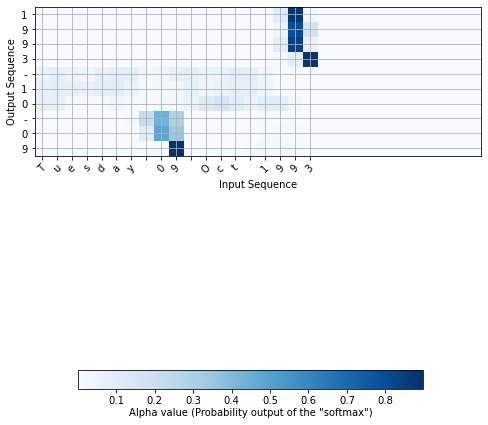

In [57]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)

在生成的图上，您可以观察预测输出的每个字符的注意权重值。检查此图并检查网络注意的位置对您有意义，在日期翻译应用程序中，您将观察到大多数时间注意力有助于预测年份，并且对预测日期/月份没有太大影响

需要记住的是：
- 机器翻译模型可用于从一个序列映射到另一个序列。 它们不仅可用于翻译人类语言（如法语 - >英语），还可用于日期格式翻译等任务
- 注意机制允许网络在生成输出的特定部分时关注输入的最相关部分
- 使用注意机制的网络可以从长度为$T_x$的输入转换位长度位$T_y$的输出，其中$T_x$和$T_y$可以不同
- 你可以将注意力权重$α^{<t,t'>}$可视化，查看在生成每个输出时网络正在关注什么

您现在可以实现注意模型并使用它来学习从一个序列到另一个序列的复杂映射